In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [126]:
df= pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [127]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [128]:
df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna('NA')

In [129]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [130]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

assert len(df) == (len(df_train) + len(df_val) + len(df_test))

In [131]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [132]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [133]:
from sklearn.metrics import roc_auc_score, roc_curve

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f"{c}: {auc}")

number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


In [134]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc


dv = DictVectorizer()
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [135]:
roc_auc_score(y_val, y_pred)

0.9211964337072188

In [136]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [137]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [138]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,171,122,0,0,0.583618,1.000000
10,0.1,168,94,3,28,0.641221,0.982456
20,0.2,165,71,6,51,0.699153,0.964912
30,0.3,164,49,7,73,0.769953,0.959064
40,0.4,158,33,13,89,0.827225,0.923977
50,0.5,153,27,18,95,0.850000,0.894737
60,0.6,143,15,28,107,0.905063,0.836257
70,0.7,135,11,36,111,0.924658,0.789474
80,0.8,128,7,43,115,0.948148,0.748538
90,0.9,102,6,69,116,0.944444,0.596491


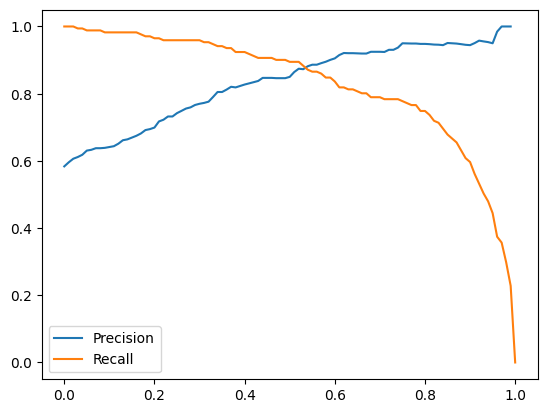

In [139]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [140]:
df_scores['f1']= 2 * (df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])


In [142]:
df_scores[df_scores.f1.max() == df_scores.f1]

,threshold,tp,fp,fn,tn,precision,recall,f1
52,0.52,153,22,18,100,0.874286,0.894737,0.884393


In [149]:
from sklearn.model_selection import KFold
import numpy as np

scores=[]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv = DictVectorizer()
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='liblinear', max_iter=1000)
    model.fit(X_train, y_train)

    val_dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.876 +- 0.032


In [153]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv = DictVectorizer()
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        val_dicts = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f' % (C, np.mean(scores)))

C=1e-06 0.561
C=0.001 0.926
C=1 0.876
